### **Import needed modules**

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

print ('modules loaded')

modules loaded


### **Read data and store it in dataframe**

In [2]:
# Generate data paths with labels
data_dir = '/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
df

filepaths labels
0      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
1      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
2      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
3      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
4      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
...                                                  ...    ...
99995  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99996  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99997  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99998  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99999  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR

[100000 rows x 2 columns]

### **Split data into train, valid, and test**

In [3]:
train_df, dummy_df = train_test_split(df,  train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])

valid_df, test_df = train_test_split(dummy_df,  train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])

### **Create image data generator**

In [4]:
# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator() # you can add data augmentation parameters here
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 80000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.


### **Show sample from train data**

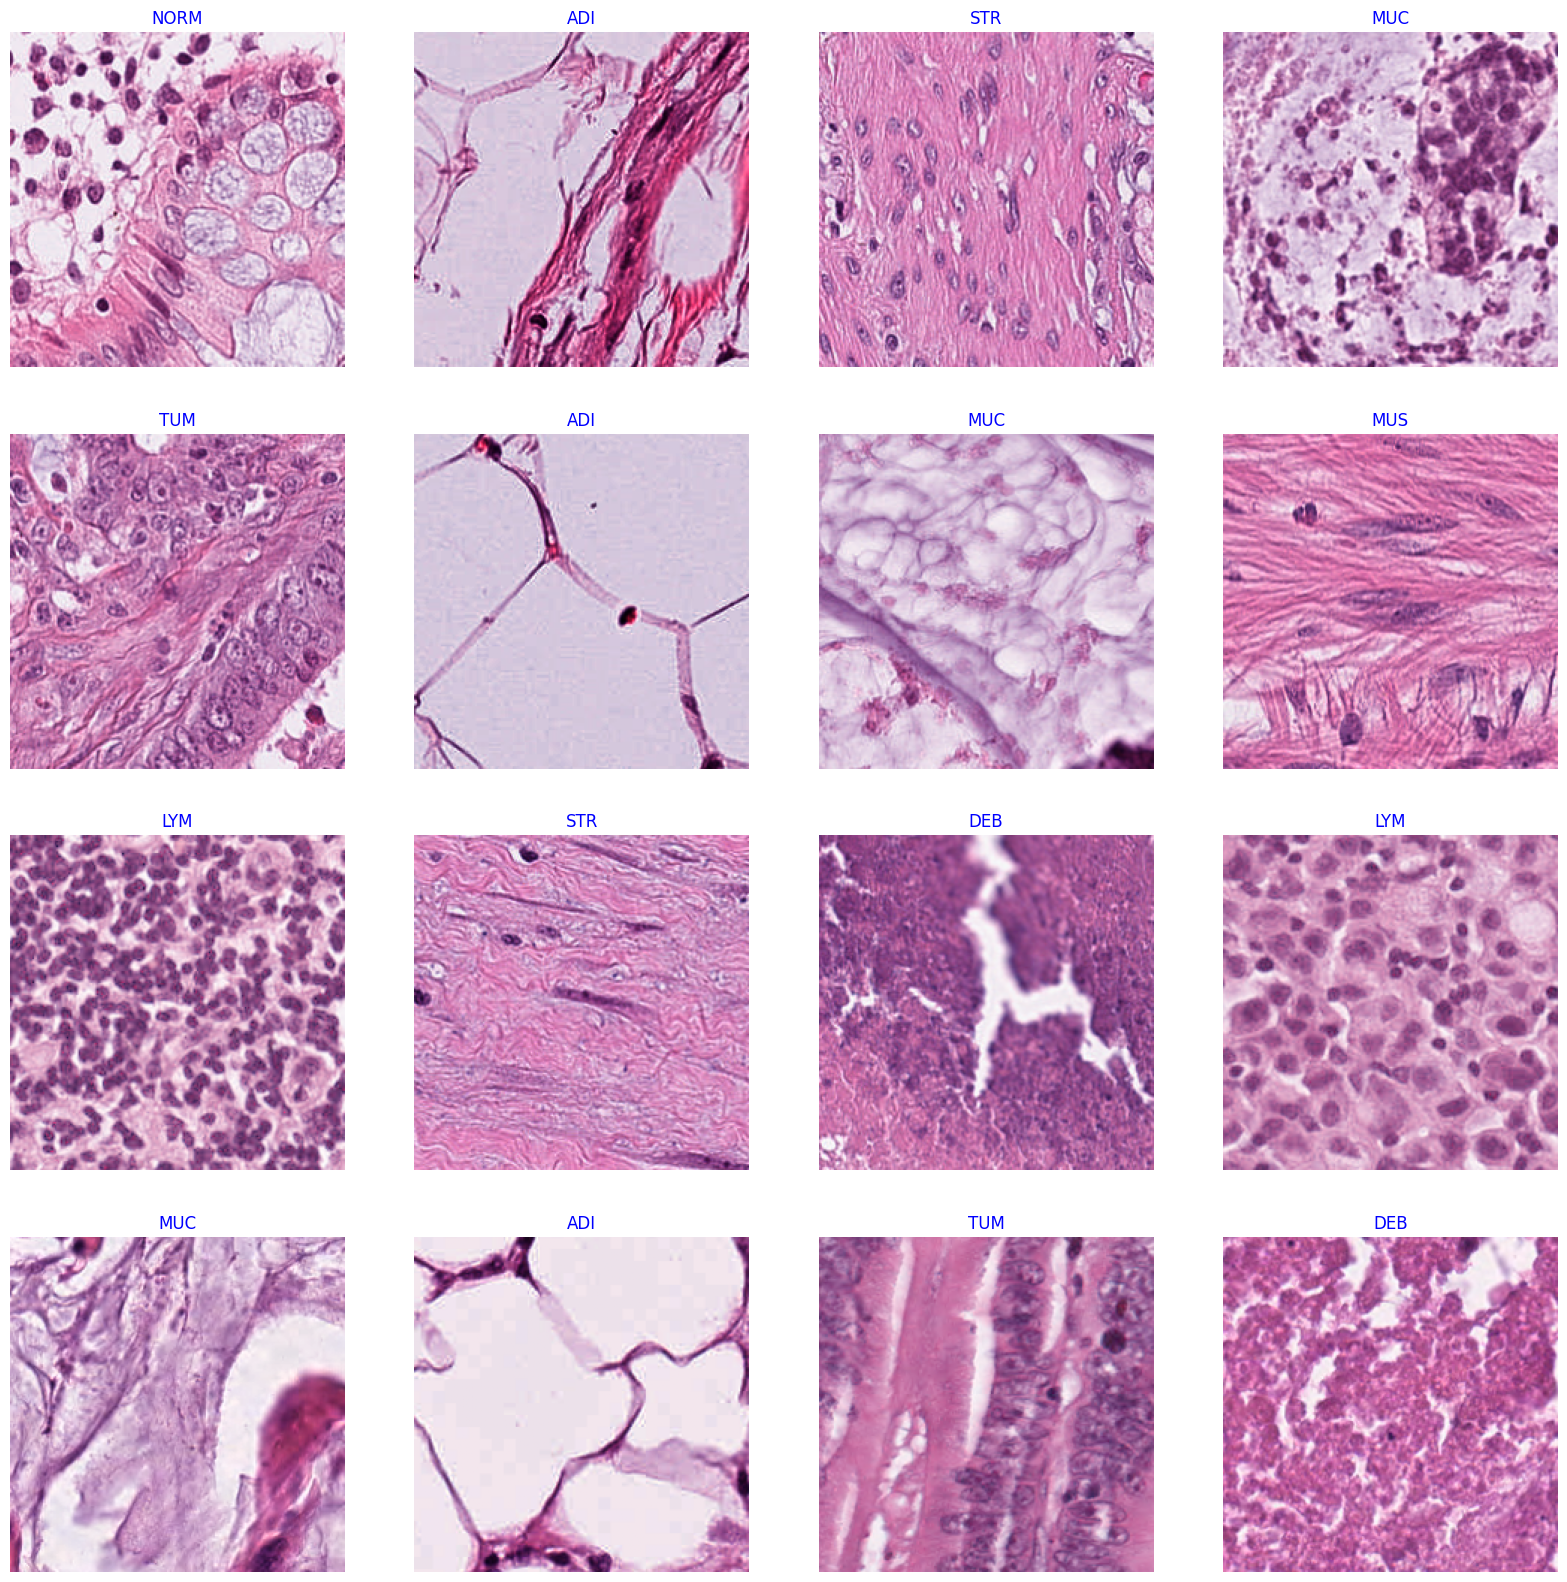

In [5]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### **Model Architecture**

In [6]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in output layer

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet", 
                                                               input_shape=img_shape, pooling='max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### **Train model**

In [8]:
history = model.fit(x=train_gen, epochs=20, verbose=1, validation_data=valid_gen)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730537369.982509     116 service.cc:145] XLA service 0x784fd80034a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730537369.982565     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730537444.028045     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 608s 800ms/step - accuracy: 0.7480 - loss: 0.7867 - val_accuracy: 0.8859 - val_loss: 0.3297
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 411ms/step - accuracy: 0.8524 - loss: 0.4252 - val_accuracy: 0.8990 - val_loss: 0.2987
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 273s 432ms/step - accuracy: 0.8718 - loss: 0.3748 - val_accuracy: 0.9048 - val_loss: 0.2785
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 275s 358ms/step - accuracy: 0.8796 - loss: 0.3468 - val_accuracy: 0.9122 - val_loss: 0.2633
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 247s 392ms/step - accuracy: 0.8891 - loss: 0.3212 - val_accuracy: 0.9156 - val_loss: 0.2553
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 378ms/step - accuracy: 0.8920 - loss: 0.3119 - val_accuracy: 0.9200 - val_loss: 0.2427
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 367ms/step - accuracy: 0.9023 - loss: 0.2893 - val_accuracy: 0.9196 - val_loss: 0.2379
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 228s 361ms/step - accuracy: 0.9012 - loss: 0.28

### **Model Evaluation**

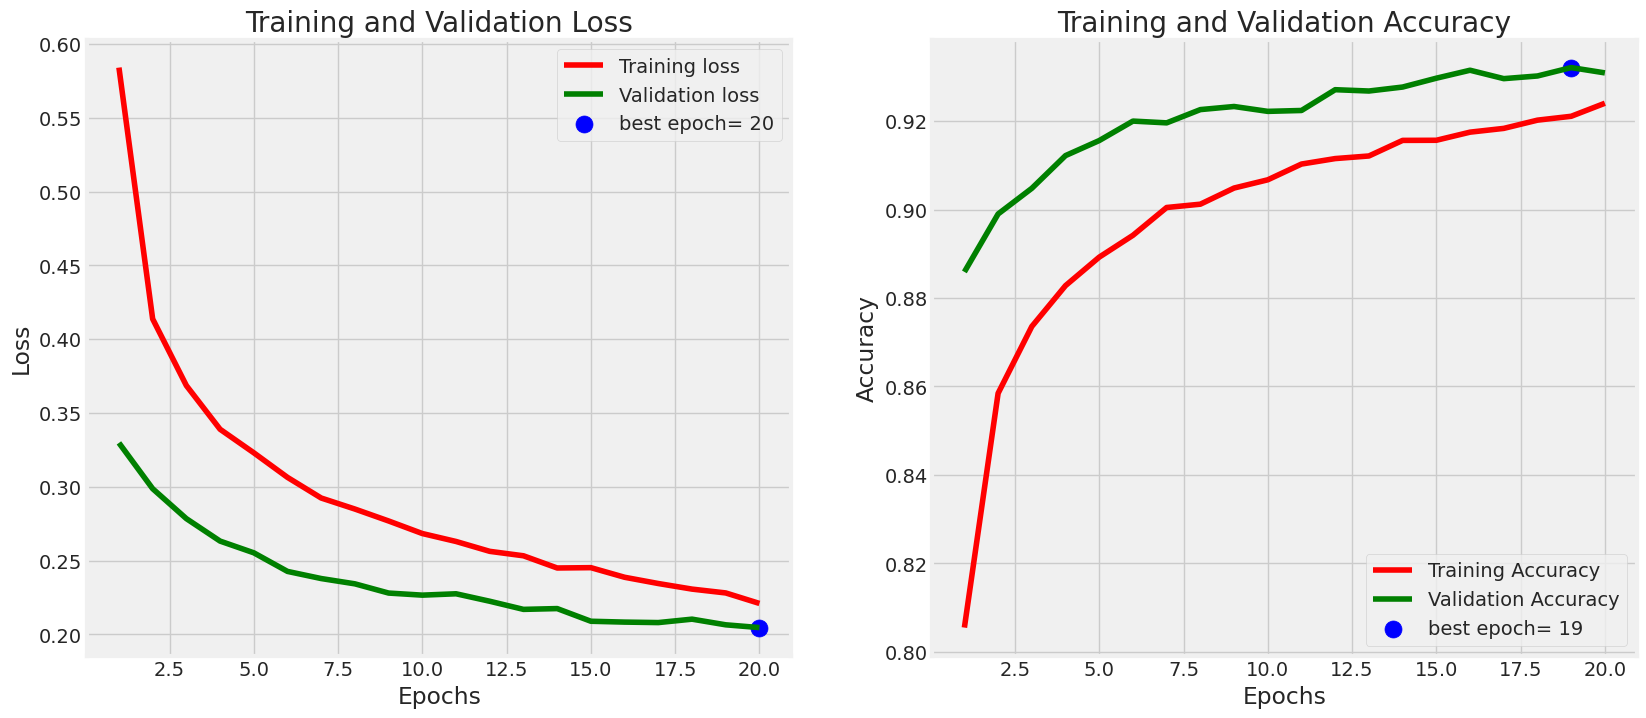

In [9]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [10]:
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 432ms/step - accuracy: 0.9563 - loss: 0.1338
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 472ms/step - accuracy: 0.9300 - loss: 0.2101


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 77s 975ms/step - accuracy: 0.9304 - loss: 0.2137
Train Loss:  0.13255098462104797
Train Accuracy:  0.9565500020980835
--------------------
Valid Loss:  0.20467448234558105
Valid Accuracy:  0.930899977684021
--------------------
Test Loss:  0.2055889219045639
Test Accuracy:  0.9316999912261963


### **Testing Evaluation**

In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step


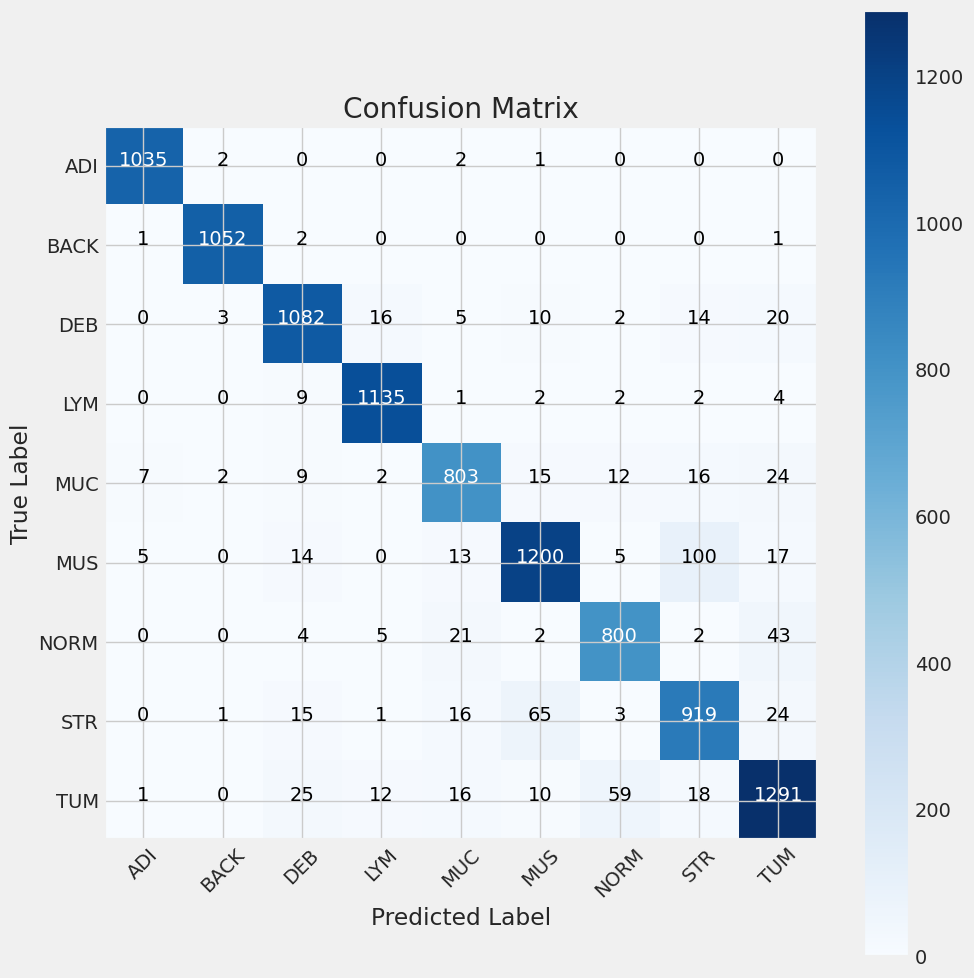

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         ADI       0.99      1.00      0.99      1040
        BACK       0.99      1.00      0.99      1056
         DEB       0.93      0.94      0.94      1152
         LYM       0.97      0.98      0.98      1155
         MUC       0.92      0.90      0.91       890
         MUS       0.92      0.89      0.90      1354
        NORM       0.91      0.91      0.91       877
         STR       0.86      0.88      0.87      1044
         TUM       0.91      0.90      0.90      1432

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



### **Save model**

In [15]:
#Save the model
model.save('Model.h5')

### **Prediction using loaded_model**

In [16]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
classes

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

In [20]:
image_path = '/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/ADI/ADI-AACCGLYD.tif'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)

# Get classes names
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# get prediction
score = tf.nn.softmax(predictions[0])
print(f"{classes[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
ADI
